In [349]:
import warnings
warnings.simplefilter('ignore')

In [350]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
#import xgboost as xgb, lightgbm as lgbm, 
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [351]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [352]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [353]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [354]:
def imput_missing_values(df, list_to_predict_feature, feature_name):
    models = [{'name': 'Forest_reg', 'function': RandomForestRegressor(n_estimators=100, max_depth=3)}, 
              {'name': 'GradientBoost_reg', 'function': GradientBoostingRegressor()},
              {'name': 'Linear_reg', 'function': LinearRegression()}]
    sclx = StandardScaler()
    scly = StandardScaler()
    X_train_test_predict_feature = df[list_to_predict_income].iloc[:,:]  
    y_train_test_predict_feature = df[feature_name].iloc[:]
    ind_feature_pred = np.where(y_train_test_predict_feature.isna()==True)[0]
    X_predict= X_train_test_predict_feature.iloc[ind_feature_pred,:]
    ind_feature_test_train = np.where(y_train_test_predict_feature.isna() == False)[0]
    X_train_test= X_train_test_predict_feature.iloc[ind_feature_test_train,:]
    y_train_test= y_train_test_predict_feature.iloc[ind_feature_test_train]
    X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.2)
    sclx.fit(X_train)
    scly.fit(y_train.values.reshape((-1,1)))
    result=[]
    
    for model in models:
        model['function'].fit(sclx.transform(X_train), scly.transform(y_train.values.reshape((-1,1))))
        y_val=scly.inverse_transform(model['function'].predict(sclx.transform(X_test)))
        model['result'] = y_val
        r2=r2_score(np.array(y_test), y_val)
        model['r2_score']= r2
    best_score = models[0]['r2_score']
    best_model = models[0]
    for model in models:
        if model['r2_score']> best_score:
            best_score = model['r2_score']
            best_model = model
    df[feature_name].values[ind_feature_pred]=scly.inverse_transform(best_model['function'].predict(sclx.transform(X_predict)))
    return best_model, best_score, df

In [355]:
# input
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
PREP_DATASET_PATH ='course_project_train_prep.csv'
PREP_DATASET_TRARGET_PATH = 'course_project_train_prep_target.csv'


In [356]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [357]:
df_train.shape

(7500, 17)

In [358]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [359]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [360]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [361]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [362]:
pd.crosstab(df_train['Tax Liens'], df_train['Credit Default'])

Credit Default,0,1
Tax Liens,,
0.0,5301,2065
1.0,59,24
2.0,15,15
3.0,5,5
4.0,3,3
5.0,1,1
6.0,2,0
7.0,1,0


In [363]:
pd.crosstab(df_train['Tax Liens'], df_train['Credit Default'])

Credit Default,0,1
Tax Liens,,
0.0,5301,2065
1.0,59,24
2.0,15,15
3.0,5,5
4.0,3,3
5.0,1,1
6.0,2,0
7.0,1,0


<AxesSubplot:xlabel='Number of Open Accounts'>

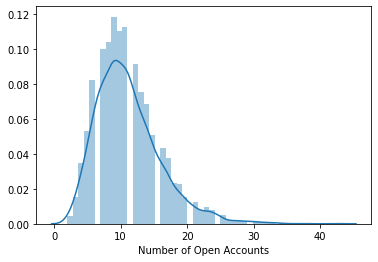

In [364]:
sns.distplot(df_train['Number of Open Accounts'])

In [365]:
pd.crosstab(df_train['Number of Open Accounts'], df_train['Credit Default'])

Credit Default,0,1
Number of Open Accounts,,
2.0,19,9
3.0,71,24
4.0,156,56
5.0,231,94
6.0,374,130
7.0,455,158
8.0,480,158
9.0,513,215
10.0,480,197


In [366]:
pd.crosstab(df_train['Years in current job'], df_train['Credit Default'])

Credit Default,0,1
Years in current job,,
1 year,362,142
10+ years,1688,644
2 years,512,193
3 years,450,170
4 years,338,131
5 years,371,145
6 years,302,124
7 years,285,111
8 years,247,92


In [367]:
pd.crosstab(df_train['Purpose'], df_train['Credit Default'])

Credit Default,0,1
Purpose,,
business loan,74,55
buy a car,72,24
buy house,25,9
debt consolidation,4290,1654
educational expenses,9,1
home improvements,304,108
major purchase,31,9
medical bills,49,22
moving,9,2


In [368]:
pd.crosstab(df_train['Number of Credit Problems'], df_train['Credit Default'])

Credit Default,0,1
Number of Credit Problems,,
0.0,4654,1815
1.0,641,241
2.0,60,33
3.0,21,14
4.0,3,6
5.0,3,4
6.0,4,0
7.0,1,0


In [369]:
pd.crosstab(df_train['Home Ownership'], df_train['Credit Default'])

Credit Default,0,1
Home Ownership,,
Have Mortgage,10,2
Home Mortgage,2721,916
Own Home,455,192
Rent,2201,1003


<AxesSubplot:xlabel='Months since last delinquent'>

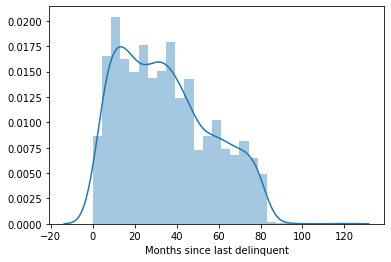

In [370]:
sns.distplot(df_train.loc[df_train['Months since last delinquent'].notnull(), 'Months since last delinquent'])

In [371]:
pd.crosstab(df_train['Bankruptcies'], df_train['Credit Default'])

Credit Default,0,1
Bankruptcies,,
0.0,4782,1878
1.0,569,217
2.0,20,11
3.0,5,2
4.0,1,1


In [372]:
pd.crosstab(df_train['Term'], df_train['Credit Default'])

Credit Default,0,1
Term,,
Long Term,1128,816
Short Term,4259,1297


In [373]:
pd.crosstab(df_train['Months since last delinquent'], df_train['Credit Default'])

Credit Default,0,1
Months since last delinquent,,
0.0,12,6
1.0,15,11
2.0,18,7
3.0,22,8
4.0,16,15
...,...,...
84.0,0,1
86.0,0,1
91.0,1,0


<AxesSubplot:xlabel='Annual Income'>

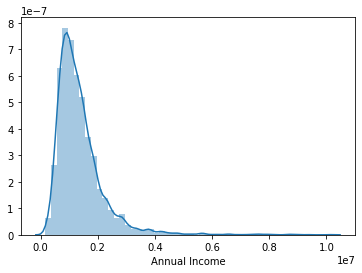

In [374]:
sns.distplot(df_train[pd.notnull(df_train['Annual Income'])]['Annual Income'])

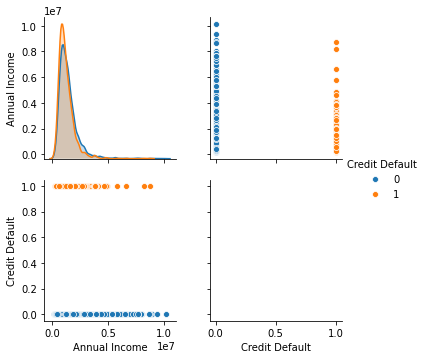

In [375]:
sns.pairplot(df_train.loc[:, ['Annual Income', 'Credit Default']], hue='Credit Default')

<AxesSubplot:xlabel='Annual Income'>

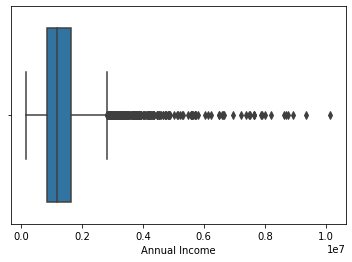

In [376]:
sns.boxplot(df_train['Annual Income'])

In [377]:
df_train['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

In [378]:
df_defaul1=df_train[df_train['Credit Default']==1]

In [379]:
df_defaul0=df_train[df_train['Credit Default']==0]

<AxesSubplot:xlabel='Credit Score'>

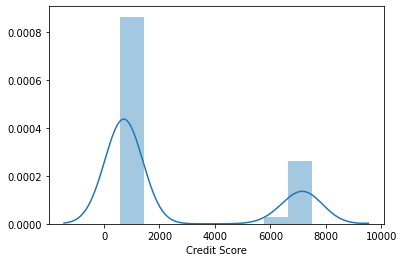

In [380]:
sns.distplot(df_defaul1[pd.notnull(df_defaul1['Credit Score'])]['Credit Score'])


In [381]:
df_defaul0['Credit Score'].std()

25.412545225110982

<AxesSubplot:xlabel='Credit Score'>

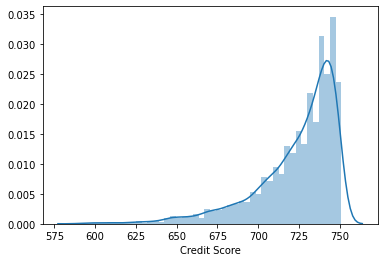

In [382]:
sns.distplot(df_defaul0[pd.notnull(df_defaul0['Credit Score'])]['Credit Score'])

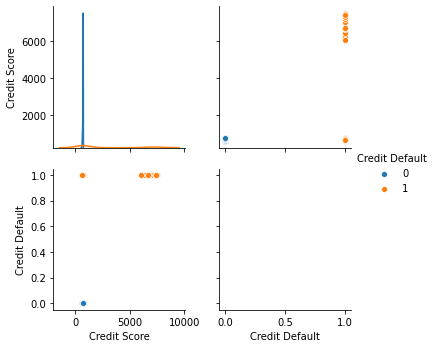

In [383]:
sns.pairplot(df_train.loc[:, ['Credit Score', 'Credit Default']], hue='Credit Default')

In [384]:
df_train.corr()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
Annual Income,1.000000,0.066245,0.188524,0.186531,0.062218,-0.015407,-0.101787,-0.066877,0.032082,0.386481,0.584819,-0.037832,-0.101375
Tax Liens,0.066245,1.000000,-0.005360,0.009109,-0.002410,0.595339,0.052446,0.057360,-0.007835,-0.010195,0.027211,0.010581,0.024368
Number of Open Accounts,0.188524,-0.005360,1.000000,0.144819,0.023897,-0.017813,-0.032740,-0.019130,0.001346,0.267325,0.413904,0.016095,0.028884
Years of Credit History,0.186531,0.009109,0.144819,1.000000,0.029247,0.071259,-0.015375,0.085699,0.010623,0.217856,0.191978,-0.015683,-0.020567
Maximum Open Credit,0.062218,-0.002410,0.023897,0.029247,1.000000,-0.004750,-0.003849,-0.011650,-0.002334,0.088090,0.010197,-0.009136,-0.014275
Number of Credit Problems,-0.015407,0.595339,-0.017813,0.071259,-0.004750,1.000000,0.139905,0.730751,-0.008596,-0.124137,-0.042252,-0.018473,0.020088
Months since last delinquent,-0.101787,0.052446,-0.032740,-0.015375,-0.003849,0.139905,1.000000,0.162710,0.000459,-0.027198,-0.057702,-0.004395,0.002598
Bankruptcies,-0.066877,0.057360,-0.019130,0.085699,-0.011650,0.730751,0.162710,1.000000,-0.005987,-0.142849,-0.079579,-0.027488,0.001648
Current Loan Amount,0.032082,-0.007835,0.001346,0.010623,-0.002334,-0.008596,0.000459,-0.005987,1.000000,0.016672,-0.009382,-0.108552,-0.226522
Current Credit Balance,0.386481,-0.010195,0.267325,0.217856,0.088090,-0.124137,-0.027198,-0.142849,0.016672,1.000000,0.504964,-0.006159,-0.019522


### Обработка пропусков в данных

In [385]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [386]:
#df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = df_train['Annual Income'].median()

In [387]:
list_to_predict_income =['Monthly Debt', 
                         'Current Credit Balance', 
                         #'Bankruptcies', 
                         'Years of Credit History',
                         'Number of Open Accounts',
                         'Maximum Open Credit',
                         #'Tax Liens',
                         'Current Loan Amount',
                         #'Number of Credit Problems'
                        ]

In [388]:
best_model, score, df_1 = imput_missing_values(df_train.copy(),list_to_predict_income, feature_name='Annual Income' )

In [389]:
df_train=df_1

In [390]:
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = 'unemployed'

In [391]:
df_train=df_train.drop(['Months since last delinquent'], axis=1)

In [392]:
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = random.choices([0.0,1.0,2.0,3.0,4.0],weights=[0.8, 0.1, 0.005, 0.001, 0.0005])[0]

In [393]:
df_train.loc[df_train['Credit Score']<755, 'Credit Score'] = 0

In [394]:
df_train.loc[df_train['Credit Score']>=755, 'Credit Score'] = 1

In [395]:
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = 2

In [396]:
pd.crosstab(df_train['Credit Score'], df_train['Credit Default'])

Credit Default,0,1
Credit Score,,
0.0,4359,1184
1.0,0,400
2.0,1028,529


In [397]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Home Ownership             7500 non-null   object 
 1   Annual Income              7500 non-null   float64
 2   Years in current job       7500 non-null   object 
 3   Tax Liens                  7500 non-null   float64
 4   Number of Open Accounts    7500 non-null   float64
 5   Years of Credit History    7500 non-null   float64
 6   Maximum Open Credit        7500 non-null   float64
 7   Number of Credit Problems  7500 non-null   float64
 8   Bankruptcies               7500 non-null   float64
 9   Purpose                    7500 non-null   object 
 10  Term                       7500 non-null   object 
 11  Current Loan Amount        7500 non-null   float64
 12  Current Credit Balance     7500 non-null   float64
 13  Monthly Debt               7500 non-null   float

In [398]:
df_train['Bankruptcies'].value_counts()

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

### Приведение типов

In [399]:
for colname in ['Tax Liens','Home Ownership', 'Years in current job', 'Purpose', 'Term', 'Number of Credit Problems', 'Bankruptcies', 'Credit Score']:
    df_train[colname] = df_train[colname].astype(str)

In [400]:
df_train.dtypes

Home Ownership                object
Annual Income                float64
Years in current job          object
Tax Liens                     object
Number of Open Accounts      float64
Years of Credit History      float64
Maximum Open Credit          float64
Number of Credit Problems     object
Bankruptcies                  object
Purpose                       object
Term                          object
Current Loan Amount          float64
Current Credit Balance       float64
Monthly Debt                 float64
Credit Score                  object
Credit Default                 int64
dtype: object

In [401]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years     2332
2 years        705
3 years        620
< 1 year       563
5 years        516
1 year         504
4 years        469
6 years        426
7 years        396
unemployed     371
8 years        339
9 years        259
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Credit Problems

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name

### Выделить целевую переменную в отделный DF

In [402]:
df_train_target = df_train.loc[:, ['Credit Default']]


In [403]:
df_train=df_train.drop(['Credit Default'], axis=1)

In [404]:
df_train_target.to_csv(PREP_DATASET_TRARGET_PATH, index=False, encoding='utf-8')

In [405]:
df_train.to_csv('trai_dump1.csv', index=False, encoding='utf-8')

### Построение новых признаков

In [243]:
#df_train['ID'] = df.index.tolist()

In [244]:
for cat_colname in df_train.select_dtypes(include='object').columns[1:]:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)

In [245]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 68 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Home Ownership                   7500 non-null   object 
 1   Annual Income                    7500 non-null   float64
 2   Years in current job             7500 non-null   object 
 3   Tax Liens                        7500 non-null   object 
 4   Number of Open Accounts          7500 non-null   float64
 5   Years of Credit History          7500 non-null   float64
 6   Maximum Open Credit              7500 non-null   float64
 7   Number of Credit Problems        7500 non-null   object 
 8   Bankruptcies                     7500 non-null   object 
 9   Purpose                          7500 non-null   object 
 10  Term                             7500 non-null   object 
 11  Current Loan Amount              7500 non-null   float64
 12  Current Credit Balan

In [246]:
categorical_columns = df_train.columns[df_train.dtypes == 'object']

In [247]:
categorical_columns

Index(['Home Ownership', 'Years in current job', 'Tax Liens',
       'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term',
       'Credit Score'],
      dtype='object')

In [248]:
df_train = df_train.drop(categorical_columns, axis=1)

In [249]:
df_train

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Current Loan Amount,Current Credit Balance,Monthly Debt,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,...,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term,Credit Score_0.0,Credit Score_1.0,Credit Score_2.0
0,4.820870e+05,11.0,26.3,685960.0,99999999.0,47386.0,7914.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,1.025487e+06,15.0,15.3,1181730.0,264968.0,394972.0,18373.0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
2,7.514120e+05,11.0,35.0,1182434.0,99999999.0,308389.0,13651.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,8.050680e+05,8.0,22.5,147400.0,121396.0,95855.0,11338.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,7.762640e+05,13.0,13.6,385836.0,125840.0,93309.0,7180.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,4.021920e+05,3.0,8.5,107866.0,129360.0,73492.0,1900.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
7496,1.533984e+06,10.0,26.5,686312.0,444048.0,456399.0,12783.0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
7497,1.878910e+06,12.0,32.1,1778920.0,99999999.0,477812.0,12479.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
7498,2.224109e+06,21.0,26.5,1141250.0,615274.0,476064.0,37118.0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [250]:
df_train.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

### Загрузка данных

In [251]:
df_train_prep = pd.read_csv(PREP_DATASET_PATH) 
df_train_target_prep=pd.read_csv(PREP_DATASET_TRARGET_PATH) 

In [252]:
TARGET_NAME = 'Credit Default'

### Отбор признаков

In [253]:
NUMERICAL_FEATURES=list(df_train_prep)[:7]

### Нормализация данных

In [254]:
scaler = StandardScaler()

df_norm = df_train_prep.copy()
df_norm[NUMERICAL_FEATURES] = scaler.fit_transform(df_norm[NUMERICAL_FEATURES])

df = df_norm.copy()

### Рабиение тренировочного дата-сета на обучающую и контрольную выборки

In [255]:
X = df
y = df_train_target_prep[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [256]:
X_train.shape

(5250, 60)

In [257]:
X_test.shape

(2250, 60)

### Балансировка целевой переменной

In [258]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [259]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и тестового датасетов

In [260]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

### Случайный лес

In [330]:
clf1 = RandomForestClassifier(n_estimators=100,max_depth=4 )
clf1.fit(X_train, y_train)
y_train_pred=clf1.predict(X_train)
y_test_pred = clf1.predict(X_test)

In [331]:
clf1

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [332]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.97      0.77      3771
           1       0.89      0.32      0.47      2958

    accuracy                           0.68      6729
   macro avg       0.77      0.64      0.62      6729
weighted avg       0.75      0.68      0.64      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.96      0.86      1616
           1       0.74      0.29      0.42       634

    accuracy                           0.77      2250
   macro avg       0.76      0.63      0.64      2250
weighted avg       0.77      0.77      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1552   64
1                450  184


In [333]:
clf1.feature_importances_

array([4.41251120e-02, 9.77371318e-03, 1.46084694e-02, 3.23086447e-02,
       2.03814179e-01, 1.09052537e-02, 1.72866598e-02, 3.27002689e-05,
       1.65121996e-03, 9.58500130e-04, 1.15691857e-03, 3.32102128e-04,
       5.78110534e-04, 3.63370248e-04, 1.66287112e-03, 1.81470851e-04,
       6.19086494e-05, 4.17790470e-04, 2.69193038e-03, 1.93034851e-03,
       5.79312057e-04, 2.39073226e-03, 2.99659483e-04, 7.41600004e-05,
       1.95104088e-05, 2.68831395e-05, 0.00000000e+00, 1.14527915e-03,
       3.24597078e-04, 9.67641777e-04, 2.16548778e-04, 1.48159612e-05,
       4.26058031e-04, 2.42430673e-05, 0.00000000e+00, 4.44365303e-04,
       7.07478669e-04, 2.34976923e-04, 0.00000000e+00, 0.00000000e+00,
       2.27657900e-03, 1.45605669e-03, 3.29025815e-04, 2.13691252e-03,
       0.00000000e+00, 2.52069278e-03, 7.58724233e-04, 1.22685563e-03,
       3.76072629e-05, 3.42773388e-04, 1.42371549e-05, 8.23972292e-03,
       6.68585388e-05, 3.15678244e-04, 2.93734428e-04, 8.43664665e-02,
      

### Градиентный бустинг

In [264]:
clf2 = GradientBoostingClassifier (learning_rate=0.05,max_depth=3)
clf2.fit(X_train, y_train)
y_train_pred=clf2.predict(X_train)
y_test_pred = clf2.predict(X_test)

In [265]:
clf2

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [266]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.89      0.78      3771
           1       0.78      0.51      0.62      2958

    accuracy                           0.72      6729
   macro avg       0.74      0.70      0.70      6729
weighted avg       0.74      0.72      0.71      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1616
           1       0.59      0.46      0.51       634

    accuracy                           0.76      2250
   macro avg       0.70      0.67      0.68      2250
weighted avg       0.74      0.76      0.75      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1415  201
1                345  289


### Voting Classifier

In [267]:

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

clf3_1 = LogisticRegression(max_iter=1000)
clf3_2 = RandomForestClassifier(n_estimators=100, max_depth=3)
clf3_3 = GaussianNB()
clf3_4 = GradientBoostingClassifier (learning_rate=0.05,max_depth=3)

clf3 = VotingClassifier(estimators=[('rf', clf3_2),('gb', clf3_4)],voting='hard')

clf3.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=3,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=100,
                                                     n_jobs=None,
             

In [268]:
y_train_pred=clf3.predict(X_train)
y_test_pred = clf3.predict(X_test)

In [269]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.97      0.77      3771
           1       0.89      0.30      0.45      2958

    accuracy                           0.68      6729
   macro avg       0.76      0.63      0.61      6729
weighted avg       0.75      0.68      0.63      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      1616
           1       0.77      0.29      0.42       634

    accuracy                           0.78      2250
   macro avg       0.77      0.63      0.64      2250
weighted avg       0.77      0.78      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1562   54
1                451  183


### KNN

In [270]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      3771
           1       0.81      0.71      0.76      2958

    accuracy                           0.80      6729
   macro avg       0.80      0.79      0.79      6729
weighted avg       0.80      0.80      0.80      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1616
           1       0.44      0.46      0.45       634

    accuracy                           0.68      2250
   macro avg       0.61      0.62      0.61      2250
weighted avg       0.69      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1246  370
1                343  291


### LogisticRegression

In [291]:
clf4 = LogisticRegression(random_state=3, max_iter=1000, penalty='l1')

In [292]:
clf4.fit(X_train, y_train)

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=3, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [293]:
y_train_pred=clf4.predict(X_train)
y_test_pred = clf4.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.83      0.75      3771
           1       0.71      0.53      0.61      2958

    accuracy                           0.70      6729
   macro avg       0.70      0.68      0.68      6729
weighted avg       0.70      0.70      0.69      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1616
           1       0.53      0.52      0.53       634

    accuracy                           0.73      2250
   macro avg       0.67      0.67      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1323  293
1                304  330


### CatBoost

In [295]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.53      0.69      3771
           1       0.63      1.00      0.77      2958

    accuracy                           0.74      6729
   macro avg       0.81      0.77      0.73      6729
weighted avg       0.83      0.74      0.73      6729

TEST

              precision    recall  f1-score   support

           0       0.89      0.42      0.57      1616
           1       0.37      0.86      0.52       634

    accuracy                           0.54      2250
   macro avg       0.63      0.64      0.54      2250
weighted avg       0.74      0.54      0.55      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               676  940
1                86  548


In [296]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [297]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [298]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 1min 54s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000029FFEF06F88>,
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [299]:
rs.best_params_

{'n_estimators': 200, 'max_depth': 5}

In [300]:
rs.best_score_

0.5440349945224523

### Обучение и оценка финальной модели

In [307]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=5, learning_rate=0.01, 
                                      silent=True)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.90      0.77      3771
           1       0.78      0.47      0.58      2958

    accuracy                           0.71      6729
   macro avg       0.73      0.68      0.68      6729
weighted avg       0.72      0.71      0.69      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1616
           1       0.59      0.44      0.50       634

    accuracy                           0.76      2250
   macro avg       0.70      0.66      0.67      2250
weighted avg       0.74      0.76      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1426  190
1                358  276
Wall time: 2.42 s


#### Вывод: Наиболее эффективной является модель LogisticRegression

#### Подбор оптимальных параметров модели  LogisticRegression

In [315]:
from sklearn.model_selection import GridSearchCV

In [316]:
clf4 = LogisticRegression()

In [319]:
parametrs = { 'max_iter': [300, 500, 1000,2000,5000],
              'penalty': ['l1','l2'],
              'tol':[0.01,0.001, 0.0001],
              'C': [1.0, 2.0, 3.0, 5.0] }

In [320]:
grid = GridSearchCV(clf4, parametrs, cv=5)
grid.fit(X_train, y_train)

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mvideo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1.0, 2.0, 3.0, 5.0],
                         'max_iter': [300, 500, 1000, 2000, 5000],
                         'penalty': ['l1', 'l2'],
                         'tol': [0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [321]:
grid.best_params_

{'C': 1.0, 'max_iter': 300, 'penalty': 'l1', 'tol': 0.01}

In [323]:
clf4 = LogisticRegression(C= 1.0,  max_iter=300, penalty='l1', tol=0.01)

In [324]:
clf4.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.01, verbose=0,
                   warm_start=False)

In [325]:
y_train_pred=clf4.predict(X_train)
y_test_pred = clf4.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.83      0.75      3771
           1       0.71      0.53      0.61      2958

    accuracy                           0.70      6729
   macro avg       0.70      0.68      0.68      6729
weighted avg       0.70      0.70      0.69      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1616
           1       0.53      0.52      0.53       634

    accuracy                           0.74      2250
   macro avg       0.67      0.67      0.67      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1327  289
1                303  331


In [335]:
clf4.coef_[0]

array([-0.52741661,  0.09625907, -0.05920048, -8.31187325, -1.87034949,
        0.25120777,  0.31174873, -0.09145707, -0.08446287,  0.        ,
        0.0369647 , -0.06761905, -0.06317225, -0.05316192, -0.1374407 ,
        0.0852587 , -0.19801165, -0.06492854,  0.44712848, -0.18196403,
       -0.34905682,  1.25315434,  0.27884536,  0.        ,  0.        ,
        0.        ,  0.        , -0.41841047, -0.10139765,  0.14017517,
       -0.12361524,  0.        ,  0.47356127, -0.15876222,  0.        ,
        0.15093745, -0.10635731, -0.28772894,  0.        ,  0.        ,
        0.80463331, -0.38050868,  0.30389126, -0.18932593,  0.        ,
       -0.09673482, -0.31921888,  0.09939336,  0.        , -0.03693246,
        0.        ,  1.50684061,  0.        ,  0.        ,  0.        ,
        0.45558529, -0.47586478, -0.45627144,  6.31614489,  0.04147304])

In [336]:
np.array(list(df_train_prep))

array(['Annual Income', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Years in current job_1 year', 'Years in current job_10+ years',
       'Years in current job_2 years', 'Years in current job_3 years',
       'Years in current job_4 years', 'Years in current job_5 years',
       'Years in current job_6 years', 'Years in current job_7 years',
       'Years in current job_8 years', 'Years in current job_9 years',
       'Years in current job_< 1 year', 'Years in current job_unemployed',
       'Tax Liens_0.0', 'Tax Liens_1.0', 'Tax Liens_2.0', 'Tax Liens_3.0',
       'Tax Liens_4.0', 'Tax Liens_5.0', 'Tax Liens_6.0', 'Tax Liens_7.0',
       'Number of Credit Problems_0.0', 'Number of Credit Problems_1.0',
       'Number of Credit Problems_2.0', 'Number of Credit Problems_3.0',
       'Number of Credit Problems_4.0', 'Number of Credit Problems_5.0',
       'Number of Cr

In [344]:
importance = pd.DataFrame(np.absolute(clf4.coef_), columns=list(df_train_prep))

In [348]:
importance.T.sort_values(by=0)

,0
Number of Credit Problems_7.0,0.000000
Bankruptcies_3.0,0.000000
Tax Liens_7.0,0.000000
Purpose_wedding,0.000000
Purpose_vacation,0.000000
Purpose_take a trip,0.000000
Purpose_renewable energy,0.000000
Tax Liens_6.0,0.000000
Tax Liens_5.0,0.000000
Years in current job_2 years,0.000000


### Обработка менее значимых признаков

In [428]:
df_train = pd.read_csv('trai_dump1.csv')

In [429]:
df_train.loc[df_train['Bankruptcies'].isin([3,4]), 'Bankruptcies'] = 99999

In [430]:
df_train.loc[df_train['Number of Credit Problems'].isin([7,4]), 'Number of Credit Problems'] = 99999

In [431]:
df_train.loc[df_train['Number of Credit Problems'].isin([1,2,3]), 'Number of Credit Problems'] = 88888

In [432]:
df_train.loc[df_train['Tax Liens'].isin([4,5,6,7]), 'Tax Liens'] = 99999

In [433]:
df_train.loc[df_train['Purpose'].isin(['wedding','vacation','take a trip', 'renewable energy', 'educational expenses', 'moving','other']), 'Purpose'] = 'other'

In [434]:
df_train.loc[df_train['Years in current job'].isin(['2 years','3 years', '6 years', '5 years', '< 1 year', '4 years', '10+ years', '8 years', '1 year']), 'Years in current job'] = 'other'

In [435]:
for colname in ['Tax Liens','Home Ownership', 'Years in current job', 'Purpose', 'Term', 'Number of Credit Problems', 'Bankruptcies', 'Credit Score']:
    df_train[colname] = df_train[colname].astype(str)

In [436]:
df_train.select_dtypes(include='object').columns

Index(['Home Ownership', 'Years in current job', 'Tax Liens',
       'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term',
       'Credit Score'],
      dtype='object')

In [437]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)

In [439]:
categorical_columns = df_train.columns[df_train.dtypes == 'object']

In [440]:
df_train = df_train.drop(categorical_columns, axis=1)

In [441]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 43 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Annual Income                      7500 non-null   float64
 1   Number of Open Accounts            7500 non-null   float64
 2   Years of Credit History            7500 non-null   float64
 3   Maximum Open Credit                7500 non-null   float64
 4   Current Loan Amount                7500 non-null   float64
 5   Current Credit Balance             7500 non-null   float64
 6   Monthly Debt                       7500 non-null   float64
 7   Home Ownership_Have Mortgage       7500 non-null   uint8  
 8   Home Ownership_Home Mortgage       7500 non-null   uint8  
 9   Home Ownership_Own Home            7500 non-null   uint8  
 10  Home Ownership_Rent                7500 non-null   uint8  
 11  Years in current job_7 years       7500 non-null   uint8

In [442]:
NUMERICAL_FEATURES=list(df_train)[:7]

In [444]:
# номализация
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUMERICAL_FEATURES] = scaler.fit_transform(df_norm[NUMERICAL_FEATURES])

df = df_norm.copy()

In [445]:
# разбиение на test и train
X = df
y = df_train_target_prep[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [446]:
# балансировка
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [447]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Применение лучшей модели к новым признакам

In [455]:
clf4 = LogisticRegression(C= 1.0,  max_iter=1000, penalty='l2', tol=0.001)

In [456]:
clf4.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.001, verbose=0,
                   warm_start=False)

In [457]:
y_train_pred=clf4.predict(X_train)
y_test_pred = clf4.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.82      0.75      3771
           1       0.71      0.54      0.61      2958

    accuracy                           0.70      6729
   macro avg       0.70      0.68      0.68      6729
weighted avg       0.70      0.70      0.69      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1616
           1       0.52      0.52      0.52       634

    accuracy                           0.73      2250
   macro avg       0.67      0.67      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1307  309
1                302  332


In [458]:
clf4.coef_

array([[-0.49328297,  0.07484862, -0.04478601, -3.4507202 , -1.97056229,
         0.11545837,  0.32677536, -0.36169071,  0.05950168,  0.25717389,
         0.4389855 , -0.06715466, -0.11320725,  0.035464  ,  0.53886826,
        -0.33557818, -0.56910938,  1.03337925,  0.28708227, -0.0218036 ,
        -0.13236482,  0.71730735, -0.69702602,  0.30521731,  0.20083654,
         0.67198041,  0.315059  ,  0.05907451, -0.65214356,  0.62823522,
        -0.59270522,  0.27161215, -0.34830138, -0.16333999, -0.55510614,
         0.04583769, -0.20465721,  1.31239523,  0.67257591, -0.27860555,
        -1.85070717,  3.59801557, -1.35333804]])